# SVM Tuning (Descriptors + Fingerprints)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem, RDLogger, DataStructs
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem, MACCSkeys
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.ML.Descriptors import MoleculeDescriptors as md

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RepeatedStratifiedKFold,
    cross_val_score,
    cross_validate,
    RandomizedSearchCV,
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix,
)

from sklearn.svm import SVC
import shap
import optuna

/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Molecule, Descriptor + Fingerprints and Outlier Functions


In [2]:
def molecule_from_smiles(smiles):
    lg = RDLogger.logger()
    # Temporarily silence RDKit logs
    lg.setLevel(RDLogger.CRITICAL)
    try:
        # Extract molecule
        molecule = Chem.MolFromSmiles(smiles, sanitize=True)
        if molecule is None:
            return None, "failed"

        # Remove salts
        clean_molecule = rdMolStandardize.LargestFragmentChooser()
        molecule = clean_molecule.choose(molecule)

        # Sanitize molecule again to reflect changes
        Chem.SanitizeMol(molecule)
        return molecule, "succeed"
    except Exception as e:
        return None, f"error: {e}"
    finally:
        # Re-enable logging afterward
        lg.setLevel(RDLogger.INFO)


def calculate_descriptors(molecule):
    # Get all descriptors (1D/2D)
    descriptor_names = []
    for descriptor, _ in Descriptors._descList:
        descriptor_names.append(descriptor)

    # Use descriptors to calculate values
    calculator = md.MolecularDescriptorCalculator(descriptor_names)
    descriptor_values = calculator.CalcDescriptors(molecule)

    # Create dictionary
    descriptors = dict(zip(descriptor_names, descriptor_values))
    return descriptors


def compute_iqr_limits(df, factor=1.5):
    # Calculate IQR limits
    limits = {}
    for col in df.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1

        # If IQR is 0 - column is too flat - skip
        if iqr == 0 or np.isnan(iqr):
            continue

        lower = q1 - factor * iqr
        upper = q3 + factor * iqr
        limits[col] = (lower, upper)
    return limits


def apply_iqr_limits(df, limits):
    # Apply the limits
    df_clipped = df.copy()
    for col, (lower, upper) in limits.items():
        df_clipped[col] = df_clipped[col].clip(lower, upper)
    return df_clipped


def bitvect_to_dict(fp, prefix):
    # Convert bit vector to dictionary (create features)
    n_bits = fp.GetNumBits()
    arr = np.zeros((n_bits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    features = {}
    for i, v in enumerate(arr):
        features[f"{prefix}_{i}"] = int(v)
    return features


def calculate_fingerprints(mol):
    RDLogger.DisableLog("rdApp.*")
    # Calculate Morgan, RDKit, MACCS, AtomPair and Topological Torsion fingerprint
    feats = {}
    if mol is None:
        return feats

    # Morgan (ECFP) fingerprint
    morgan_bits = 2048
    morgan_radius = 2
    fp_morgan = rdMolDescriptors.GetMorganFingerprintAsBitVect(
        mol, radius=morgan_radius, nBits=morgan_bits
    )
    feats.update(bitvect_to_dict(fp_morgan, f"Morgan{morgan_radius}_{morgan_bits}"))

    # RDKit topological fingerprint
    rdk_bits = 2048
    fp_rdk = Chem.RDKFingerprint(mol, fpSize=rdk_bits)
    feats.update(bitvect_to_dict(fp_rdk, f"RDK_{rdk_bits}"))

    # MACCS keys (167 bits)
    fp_maccs = MACCSkeys.GenMACCSKeys(mol)
    feats.update(bitvect_to_dict(fp_maccs, "MACCS"))

    # AtomPair fingerprint
    ap_bits = 2048
    fp_ap = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol, nBits=ap_bits)
    feats.update(bitvect_to_dict(fp_ap, f"AtomPair_{ap_bits}"))

    # Topological torsion fingerprint
    tt_bits = 2048
    fp_tt = rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(
        mol, nBits=tt_bits
    )
    feats.update(bitvect_to_dict(fp_tt, f"Torsion_{tt_bits}"))

    RDLogger.EnableLog("rdApp.*")

    return feats

## Dataset Processing


In [ ]:
# Configuration
ORIG_DATASET = "in_chemico_dataset.xlsx"
SKIP_ROWS = 1
SMILES_COL = "SMILES code"
TARGET_COL = "Phototoxicity"
FULL_OUTPUT_DATASET = "in_chemico_dataset_processed.xlsx"

# Outputs
TRAIN_X_CSV = "in_chemico_x_train.csv"
TEST_X_CSV = "in_chemico_x_test.csv"
TRAIN_Y_CSV = "in_chemico_y_train.csv"
TEST_Y_CSV = "in_chemico_y_test.csv"

# Near constant threshold - tolerance
SIMILARITY_THRESHOLD = 0.7
# Correlation threshold
CORRELATION_THRESHOLD = 0.65

# Load dataset and skip first row (Header)
dataset = pd.read_excel(ORIG_DATASET, engine="openpyxl", skiprows=SKIP_ROWS)

descriptor_rows = []
state_molecules = []
molecules = []

for smiles in dataset[SMILES_COL].astype(str):
    molecule, state = molecule_from_smiles(smiles)
    state_molecules.append(state)
    molecules.append(molecule)

    if molecule is None:
        descriptor_rows.append({})
        continue

    # 1D/2D RDKit descriptors
    desc_feats = calculate_descriptors(molecule)

    # Calculate Morgan, RDKit, MACCS, AtomPair and Topological Torsion fingerprint
    fp_feats = calculate_fingerprints(molecule)

    # Merge both dicts into one feature row
    all_feats = {**desc_feats, **fp_feats}
    descriptor_rows.append(all_feats)

# Convert list of dictionaries into dataframe
descriptor_data_all = pd.DataFrame(descriptor_rows)

# Keep everything + status
output = pd.concat(
    [dataset.reset_index(drop=True), descriptor_data_all.reset_index(drop=True)], axis=1
)
output["MoleculeStatus"] = state_molecules

# Output whole dataset with descriptors and state
with pd.ExcelWriter(FULL_OUTPUT_DATASET, engine="openpyxl") as writer:
    output.to_excel(writer, index=False, sheet_name="Descriptors")

print(f"Full - Rows: {len(output)}/Columns: {output.shape[1]}")
print(output.head().to_string(index=False))

# Drop failed molecules - boolean array
molecules_right = []
for molecule in molecules:
    if molecule is not None:
        molecules_right.append(True)
    else:
        molecules_right.append(False)
if not any(molecules_right):
    raise ValueError("No valid molecules after SMILES parsing.")

dataset_ok = dataset.loc[molecules_right].reset_index(drop=True)
descriptor_ok = descriptor_data_all.loc[molecules_right].reset_index(drop=True)

# Target
y_full = dataset_ok[TARGET_COL].astype(int)

# Take only numeric descriptor columns
X_full = descriptor_ok.select_dtypes(include=[np.number]).copy()
for column in X_full.columns:
    X_full[column] = X_full[column].replace([np.inf, -np.inf], np.nan)

# Drop columns that are entirely NaN
all_nan_cols = X_full.columns[X_full.isna().all()].tolist()
if all_nan_cols:
    print(f"Dropping {len(all_nan_cols)} NaN columns.")
    X_full = X_full.drop(columns=all_nan_cols)

# Split dataset - train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# Calculate medians for each column in train only
train_medians = X_train.median(numeric_only=True)

# Fill missing values in both train and test using those medians
X_train = X_train.fillna(train_medians)
X_test = X_test.fillna(train_medians)

# Compute constants on train only
constant_cols = []
for col in X_train.columns:
    top_freq = X_train[col].value_counts(normalize=True, dropna=False).max()
    if top_freq >= SIMILARITY_THRESHOLD:
        constant_cols.append(col)

# Drop from train and apply same drop to test
if constant_cols:
    X_train = X_train.drop(columns=constant_cols)
    X_test = X_test.drop(columns=constant_cols)
    print(f"Dropped {len(constant_cols)} constant/almost-constant columns.")

# Compute absolute correlation matrix on training data
corr_matrix = X_train.corr().abs()
# Keep only upper triangle of the matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find columns to drop - correlation
high_corr_cols = []
for col in upper.columns:
    if any(upper[col] > CORRELATION_THRESHOLD):
        high_corr_cols.append(col)

# Drop from both train and test
if high_corr_cols:
    X_train = X_train.drop(columns=high_corr_cols)
    X_test = X_test.drop(columns=high_corr_cols)
    print(f"Dropped {len(high_corr_cols)} highly correlated columns.")

# Compute IQR limits on training data
iqr_limits = compute_iqr_limits(X_train, factor=1.5)

# Apply limits to both train and test sets
X_train = apply_iqr_limits(X_train, iqr_limits)
X_test = apply_iqr_limits(X_test, iqr_limits)

# Scaling not necessary for all models
# Splitting the dataset to Fingerprint and Descriptor sets
FP_PREFIXES = (
    "Morgan",
    "RDK_",
    "MACCS",
    "AtomPair_",
    "Torsion_",
)  # Identify fingerprint columns by prefix
fp_cols = [c for c in X_train.columns if c.startswith(FP_PREFIXES)]
desc_cols = [c for c in X_train.columns if c not in fp_cols]

print(f"Descriptor columns: {len(desc_cols)}, fingerprint columns: {len(fp_cols)}")

scaler = StandardScaler()
if desc_cols:
    X_train_desc_scaled = scaler.fit_transform(X_train[desc_cols])
    X_test_desc_scaled = scaler.transform(X_test[desc_cols])

    # Start from copies so we keep original indexing and all columns
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    # Overwrite only descriptor columns with scaled values
    X_train_scaled[desc_cols] = X_train_desc_scaled
    X_test_scaled[desc_cols] = X_test_desc_scaled
else:
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

X_train = X_train_scaled
X_test = X_test_scaled

# Save processed datasets
X_train.to_csv(TRAIN_X_CSV, index=False)
X_test.to_csv(TEST_X_CSV, index=False)
y_train.to_csv(TRAIN_Y_CSV, index=False, header=[TARGET_COL])
y_test.to_csv(TEST_Y_CSV, index=False, header=[TARGET_COL])

print(f"Train - Rows: {len(X_train)}/Columns: {X_train.shape[1]}")
print("First rows of train x:")
print(X_train.head().to_string(index=False))
print(f"Test - Rows: {len(X_test)}/Columns: {X_test.shape[1]}")
print("First rows of train y:")
print(y_train.head().to_string(index=False))
X_train.describe()

print("\nTrain set class counts:")
print(y_train.value_counts())
print("\nTrain set class ratio:")
print(y_train.value_counts(normalize=True))

print("\nTest set class counts:")
print(y_test.value_counts())
print("\nTest set class ratio:")
print(y_test.value_counts(normalize=True))

Full - Rows: 162/Columns: 8589
                          Name                                                                                              IUPAC name CAS registry number    Structure  Phototoxicity                                                      SMILES code                            Sources               Note    Unnamed: 8 Unnamed: 9  Unnamed: 10 Unnamed: 11  MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex      qed       SPS   MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  NumRadicalElectrons  MaxPartialCharge  MinPartialCharge  MaxAbsPartialCharge  MinAbsPartialCharge  FpDensityMorgan1  FpDensityMorgan2  FpDensityMorgan3  BCUT2D_MWHI  BCUT2D_MWLOW  BCUT2D_CHGHI  BCUT2D_CHGLO  BCUT2D_LOGPHI  BCUT2D_LOGPLOW  BCUT2D_MRHI  BCUT2D_MRLOW   AvgIpc  BalabanJ    BertzCT      Chi0     Chi0n     Chi0v      Chi1    Chi1n    Chi1v    Chi2n    Chi2v    Chi3n    Chi3v    Chi4n    Chi4v  HallKierAlpha           Ipc    Kappa1   Kappa2   Kappa3  Labut

## Base Model Train


In [4]:
# SVM pipeline: scale features + RBF-kernel SVM with calibrated probabilities
base_model = SVC(
    kernel="rbf",
    probability=True,
    random_state=42,
)

# Train
base_model.fit(X_train, y_train)

# Predict
y_pred = base_model.predict(X_test)
y_prob = base_model.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nModel performance (SVM):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))


Model performance (SVM):
Accuracy:  0.6667
Precision: 0.7692
Recall:    0.5556
F1 score:  0.6452
ROC AUC:   0.7926

Classification report:
              precision    recall  f1-score   support

           0      0.600     0.800     0.686        15
           1      0.769     0.556     0.645        18

    accuracy                          0.667        33
   macro avg      0.685     0.678     0.665        33
weighted avg      0.692     0.667     0.664        33



## Feature Selection


PermutationExplainer explainer: 130it [19:58,  9.29s/it]                         
/tmp/ipykernel_141469/2953739021.py:31: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train)


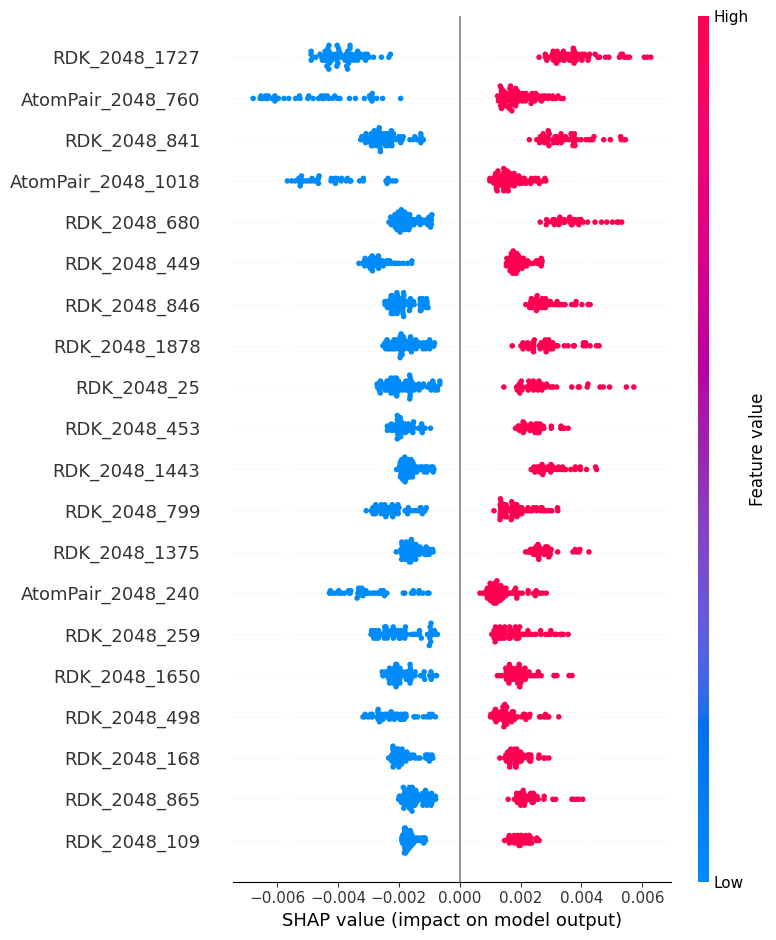


Top 10 SHAP features:
RDK_2048_1727         0.003887
AtomPair_2048_760     0.002917
RDK_2048_841          0.002891
AtomPair_2048_1018    0.002532
RDK_2048_680          0.002331
RDK_2048_449          0.002250
RDK_2048_846          0.002220
RDK_2048_1878         0.002206
RDK_2048_25           0.002199
RDK_2048_453          0.002099

Top 10 K-Best features:
RDK_2048_1727    61.730479
RDK_2048_841     37.249219
RDK_2048_34      30.766692
RDK_2048_109     30.568538
RDK_2048_449     30.043949
RDK_2048_429     29.921829
RDK_2048_1375    29.579104
RDK_2048_453     29.012759
RDK_2048_1189    26.537915
RDK_2048_865     26.473703

Top 10 Lasso features:
AtomPair_2048_760     1.334892
RDK_2048_1827         1.080289
RDK_2048_841          0.961268
MACCS_95              0.929015
AtomPair_2048_1864    0.603940
RDK_2048_1441         0.572258
VSA_EState9           0.567150
RDK_2048_84           0.530751
RDK_2048_1421         0.456557
RDK_2048_1256         0.435193


In [5]:
# SHAP features
# Prediction function for SHAP
f = lambda X: base_model.predict_proba(X)[:, 1]

explainer = shap.Explainer(f, X_train)
shap_result = explainer(X_train, max_evals=2 * X_train.shape[1] + 50)

# Each row has values for features
shap_values = shap_result.values

# Mean absolute SHAP value per feature (importance)
shap_importance = np.abs(shap_values).mean(axis=0)
shap_features = pd.Series(shap_importance, index=X_train.columns).sort_values(
    ascending=False
)

# K-Best - Anova features
kbest = SelectKBest(score_func=f_classif, k="all")
kbest.fit(X_train, y_train)
kbest_scores = pd.Series(kbest.scores_, index=X_train.columns).fillna(0.0)
kbest_features = kbest_scores.sort_values(ascending=False)

# Lasso features
lasso = LogisticRegression(penalty="l1", C=1.0, solver="liblinear", max_iter=5000)
lasso.fit(X_train, y_train)

lasso_importance = pd.Series(np.abs(lasso.coef_).ravel(), index=X_train.columns)
lasso_features = lasso_importance.sort_values(ascending=False)

# Plot
shap.summary_plot(shap_values, X_train)

# Print best features for each method
print("\nTop 10 SHAP features:")
print(shap_features.head(10).to_string())
print("\nTop 10 K-Best features:")
print(kbest_features.head(10).to_string())
print("\nTop 10 Lasso features:")
print(lasso_features.head(10).to_string())

## SHAP Features


In [6]:
shap_features.head(20)

AtomPair_2048_296     0.012097
BCUT2D_MRLOW          0.011644
SlogP_VSA8            0.011249
RDK_2048_603          0.011116
RDK_2048_498          0.010575
RDK_2048_61           0.010569
RDK_2048_96           0.010218
AtomPair_2048_1340    0.010165
fr_ether              0.010072
RDK_2048_556          0.009441
RDK_2048_148          0.009326
RDK_2048_633          0.009317
RDK_2048_308          0.008596
RDK_2048_1930         0.008291
RDK_2048_1410         0.008269
RDK_2048_259          0.008237
RDK_2048_281          0.008213
RDK_2048_1414         0.008123
RDK_2048_1115         0.008112
RDK_2048_834          0.008090
dtype: float64


CV results (training only, mean over folds):
   Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0      5     0.772059  0.722349    0.776667
1      6     0.794853  0.760018    0.793254
2      7     0.770588  0.724267    0.803889
3      8     0.770588  0.732894    0.829206
4      9     0.770588  0.732894    0.829524

Best number of features by CV F1: 42
Top_N          42.000000
CV_Accuracy     0.831618
CV_F1           0.796172
CV_ROC_AUC      0.883095
Name: 37, dtype: float64


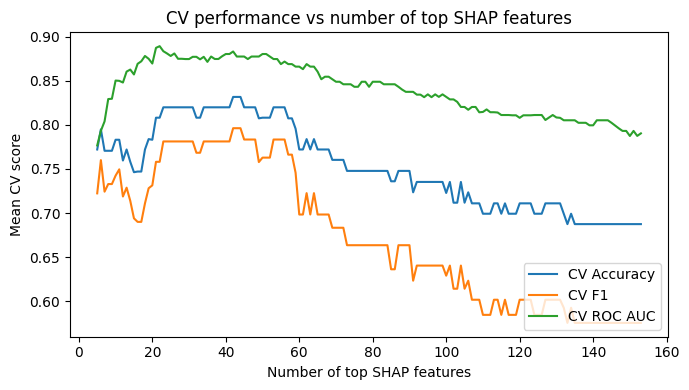

In [7]:
results = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate from top 5 features up to all
for n in range(5, len(shap_features) + 1):
    top_feats = shap_features.head(n).index

    model = SVC(
        kernel="rbf",
        probability=True,
        random_state=42,
    )

    # Cross validation
    cv_res = cross_validate(
        model,
        X_train[top_feats],
        y_train,
        cv=kf,
        scoring={"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"},
        n_jobs=-1,
        return_train_score=False,
    )

    mean_acc = cv_res["test_accuracy"].mean()
    mean_f1 = cv_res["test_f1"].mean()
    mean_auc = cv_res["test_roc_auc"].mean()

    results.append((n, mean_acc, mean_f1, mean_auc))

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

# Pick best N by CV F1
best = res_df.iloc[res_df["CV_F1"].idxmax()]
best_n = int(best.Top_N)
best_n_shap = int(best.Top_N)

print("\nCV results (training only, mean over folds):")
print(res_df.head())
print(f"\nBest number of features by CV F1: {best_n}")
print(best)

# Plot CV performance
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
plt.xlabel("Number of top SHAP features")
plt.ylabel("Mean CV score")
plt.title("CV performance vs number of top SHAP features")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## KBEST Features


In [8]:
kbest_features.head(20)

RDK_2048_498          18.313457
SlogP_VSA8            17.773131
RDK_2048_633          15.873491
RDK_2048_603          15.790976
AtomPair_2048_296     13.641103
fr_ether              12.755029
RDK_2048_1930         11.575951
RDK_2048_1520         11.492363
RDK_2048_61           11.492363
RDK_2048_259          11.492363
RDK_2048_556          11.483796
RDK_2048_96           10.923973
BCUT2D_MRLOW           9.644366
RDK_2048_281           8.350318
AtomPair_2048_1340     8.261686
RDK_2048_1905          8.074279
RDK_2048_859           8.074279
RDK_2048_1410          8.008884
RDK_2048_235           7.242026
RDK_2048_834           6.710439
dtype: float64


CV results (training only, mean over folds):
   Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0      5     0.772059  0.723077    0.743095
1      6     0.759559  0.690037    0.781032
2      7     0.747794  0.669524    0.797381
3      8     0.735294  0.645281    0.842143
4      9     0.747059  0.684982    0.816270

Best number of features by CV F1: 29
Top_N          29.000000
CV_Accuracy     0.795588
CV_F1           0.751209
CV_ROC_AUC      0.842460
Name: 24, dtype: float64


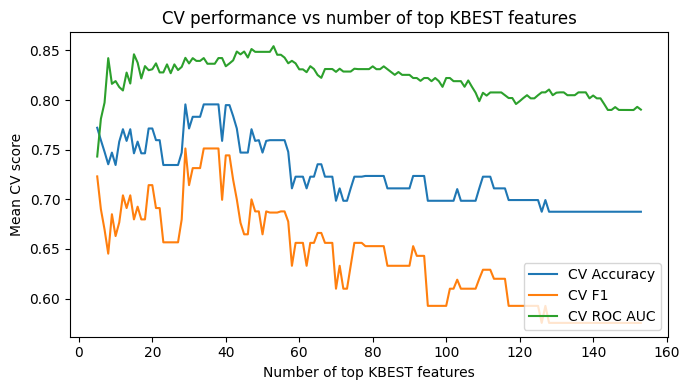

In [9]:
results = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate from top 5 features up to all
for n in range(5, len(kbest_features) + 1):
    top_feats = kbest_features.head(n).index

    # model = xgb.XGBClassifier(
    #     objective="binary:logistic", eval_metric=["logloss", "auc"], random_state=42
    # )

    model = SVC(
        kernel="rbf",
        probability=True,
        random_state=42,
    )

    # Cross validation
    cv_res = cross_validate(
        model,
        X_train[top_feats],
        y_train,
        cv=kf,
        scoring={"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"},
        n_jobs=-1,
        return_train_score=False,
    )

    mean_acc = cv_res["test_accuracy"].mean()
    mean_f1 = cv_res["test_f1"].mean()
    mean_auc = cv_res["test_roc_auc"].mean()

    results.append((n, mean_acc, mean_f1, mean_auc))

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

# Pick best N by CV F1
best = res_df.iloc[res_df["CV_F1"].idxmax()]
best_n = int(best.Top_N)
best_n_kbest = int(best.Top_N)

print("\nCV results (training only, mean over folds):")
print(res_df.head())
print(f"\nBest number of features by CV F1: {best_n}")
print(best)

# Plot CV performance
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
plt.xlabel("Number of top KBEST features")
plt.ylabel("Mean CV score")
plt.title("CV performance vs number of top KBEST features")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## LASSO Features


In [10]:
lasso_features.head(20)

RDK_2048_1138        1.212142
RDK_2048_1982        1.004276
RDK_2048_1020        0.780948
AtomPair_2048_296    0.759024
RDK_2048_1166        0.724062
RDK_2048_441         0.705387
BCUT2D_MRLOW         0.646923
AtomPair_2048_244    0.589897
AtomPair_2048_320    0.553926
RDK_2048_834         0.547698
RDK_2048_803         0.512036
RDK_2048_23          0.475541
RDK_2048_679         0.452729
RDK_2048_96          0.450340
PEOE_VSA11           0.446145
RDK_2048_1930        0.417002
RDK_2048_1414        0.395110
RDK_2048_148         0.359655
MaxPartialCharge     0.348258
RDK_2048_1140        0.337951
dtype: float64


CV results (training only, mean over folds):
   Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0      5     0.695588  0.587790    0.775278
1      6     0.731618  0.642524    0.786389
2      7     0.878676  0.862179    0.884444
3      8     0.843382  0.818370    0.860794
4      9     0.819118  0.787857    0.892063

Best number of features by CV F1: 7
Top_N          7.000000
CV_Accuracy    0.878676
CV_F1          0.862179
CV_ROC_AUC     0.884444
Name: 2, dtype: float64


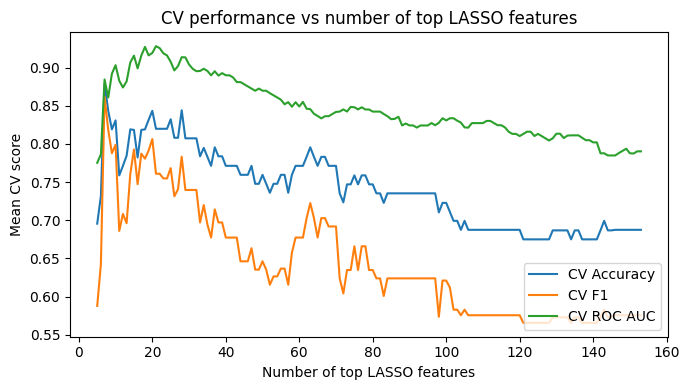

In [11]:
results = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate from top 5 features up to all
for n in range(5, len(lasso_features) + 1):
    top_feats = lasso_features.head(n).index

    model = SVC(
        kernel="rbf",
        probability=True,
        random_state=42,
    )

    # Cross validation
    cv_res = cross_validate(
        model,
        X_train[top_feats],
        y_train,
        cv=kf,
        scoring={"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"},
        n_jobs=-1,
        return_train_score=False,
    )

    mean_acc = cv_res["test_accuracy"].mean()
    mean_f1 = cv_res["test_f1"].mean()
    mean_auc = cv_res["test_roc_auc"].mean()

    results.append((n, mean_acc, mean_f1, mean_auc))

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

# Pick best N by CV F1
best = res_df.iloc[res_df["CV_F1"].idxmax()]
best_n = int(best.Top_N)
best_n_lasso = int(best.Top_N)

print("\nCV results (training only, mean over folds):")
print(res_df.head())
print(f"\nBest number of features by CV F1: {best_n}")
print(best)

# Plot CV performance
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
plt.xlabel("Number of top LASSO features")
plt.ylabel("Mean CV score")
plt.title("CV performance vs number of top LASSO features")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## Model SHAP Features


In [12]:
top_feats = shap_features.head(best_n_shap).index.tolist()

# Train final model
final_model = SVC(
    kernel="rbf",
    probability=True,
    random_state=42,
)

final_model.fit(X_train[top_feats], y_train)

# Evaluate
y_pred = final_model.predict(X_test[top_feats])
y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal model performance (SHAP) on test:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Final model performance (SHAP) on test:
Accuracy:  0.8095
Precision: 1.0000
Recall:    0.5556
F1 score:  0.7143
ROC AUC:   0.6389


## Model KBEST Features


In [13]:
top_feats = kbest_features.head(best_n_kbest).index.tolist()

# Train final model
final_model = SVC(
    kernel="rbf",
    probability=True,
    random_state=42,
)

final_model.fit(X_train[top_feats], y_train)

# Evaluate
y_pred = final_model.predict(X_test[top_feats])
y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal model performance (KBEST) on test:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Final model performance (KBEST) on test:
Accuracy:  0.7143
Precision: 0.8000
Recall:    0.4444
F1 score:  0.5714
ROC AUC:   0.5833


## Model LASSO Features


In [14]:
top_feats = lasso_features.head(best_n_lasso).index.tolist()

# Train final model
final_model = SVC(
    kernel="rbf",
    probability=True,
    random_state=42,
)

final_model.fit(X_train[top_feats], y_train)

# Evaluate
y_pred = final_model.predict(X_test[top_feats])
y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal model performance (LASSO) on test:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Final model performance (LASSO) on test:
Accuracy:  0.5714
Precision: 0.5000
Recall:    0.3333
F1 score:  0.4000
ROC AUC:   0.6759


## Model SHAP Features Tuning


In [15]:
top_feats = shap_features.head(best_n_shap).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)


# Optuna
def objective(trial):
    # ---- Optuna param space for SVM ----
    params = {
        "kernel": trial.suggest_categorical(
            "kernel", ["rbf", "linear", "poly", "sigmoid"]
        ),
        "C": trial.suggest_float("C", 1e-3, 1e3, log=True),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
        "shrinking": trial.suggest_categorical("shrinking", [True, False]),
        "tol": trial.suggest_float("tol", 1e-5, 1e-2, log=True),
        "max_iter": trial.suggest_categorical("max_iter", [-1, 1000, 2000]),
        "probability": True,  # needed if you evaluate with predicted probabilities (e.g., ROC AUC)
        "random_state": 42,
        "cache_size": 1000.0,
    }

    # gamma choice: allow "scale"/"auto" or a numeric value
    gamma_mode = trial.suggest_categorical("gamma_mode", ["scale", "auto", "float"])
    if gamma_mode == "float":
        params["gamma"] = trial.suggest_float("gamma", 1e-4, 10.0, log=True)
    else:
        params["gamma"] = gamma_mode

    # conditionals for poly/sigmoid
    if params["kernel"] == "poly":
        params["degree"] = trial.suggest_int("degree", 2, 5)
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    elif params["kernel"] == "sigmoid":
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    # for "rbf" and "linear" degree/coef0 are ignored, so we omit them

    # ---- Model ----
    model = SVC(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        # scoring="f1",
        scoring="roc_auc",
        n_jobs=-1,
    )

    return scores.mean()


# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

best_params = study.best_params.copy()

# Map gamma_mode -> gamma
gamma_mode = best_params.pop("gamma_mode", "scale")
if gamma_mode != "float":
    # 'scale' or 'auto'
    best_params["gamma"] = gamma_mode
# else: when gamma_mode == 'float', Optuna already stored a numeric 'gamma' in best_params

best_params.update(
    {
        "probability": True,  # needed for predict_proba below
        "random_state": 42,
        "cache_size": 1000.0,
    }
)

# Final model
final_model = SVC(**best_params)
final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (SHAP):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

Best trial: 5. Best value: 0.891587:   5%|▌         | 10/200 [00:00<00:03, 47.76it/s]/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
Best trial: 5. Best value: 0.891587:   6%|▌         | 12/200 [00:00<00:03, 47.76it/s]/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
Best trial: 5. Best value: 0.891587:  13%|█▎        | 26/200 [00:00<00:04, 42.43it/s]/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  w


Best trial:
  Value: 0.8965079365079365
  Params:
    kernel: poly
    C: 4.6960061188281506
    class_weight: balanced
    shrinking: True
    tol: 1.6197310006642126e-05
    max_iter: 2000
    gamma_mode: auto
    degree: 3
    coef0: 0.6545137501518339

Final Optuna model (SHAP):
Accuracy:  0.7143
Precision: 0.7143
Recall:    0.5556
F1 score:  0.6250
ROC AUC:   0.6852


## Model KBEST Features Tuning


In [ ]:
top_feats = kbest_features.head(best_n_kbest).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)


# Optuna
def objective(trial):
    # Hyperparameter search space
    # ---- Optuna param space for SVM ----
    params = {
        "kernel": trial.suggest_categorical(
            "kernel", ["rbf", "linear", "poly", "sigmoid"]
        ),
        "C": trial.suggest_float("C", 1e-3, 1e3, log=True),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
        "shrinking": trial.suggest_categorical("shrinking", [True, False]),
        "tol": trial.suggest_float("tol", 1e-5, 1e-2, log=True),
        "max_iter": trial.suggest_categorical("max_iter", [-1, 1000, 2000]),
        "probability": True,  # needed if you evaluate with predicted probabilities (e.g., ROC AUC)
        "random_state": 42,
        "cache_size": 1000.0,
    }

    # gamma choice: allow "scale"/"auto" or a numeric value
    gamma_mode = trial.suggest_categorical("gamma_mode", ["scale", "auto", "float"])
    if gamma_mode == "float":
        params["gamma"] = trial.suggest_float("gamma", 1e-4, 10.0, log=True)
    else:
        params["gamma"] = gamma_mode

    # conditionals for poly/sigmoid
    if params["kernel"] == "poly":
        params["degree"] = trial.suggest_int("degree", 2, 5)
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    elif params["kernel"] == "sigmoid":
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    # for "rbf" and "linear" degree/coef0 are ignored, so we omit them

    # ---- Model ----
    model = SVC(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        scoring="f1",
        # scoring="roc_auc",
        n_jobs=-1,
    )

    return scores.mean()


# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")


best_params = study.best_params.copy()

# Map gamma_mode -> gamma
gamma_mode = best_params.pop("gamma_mode", "scale")
if gamma_mode != "float":
    # 'scale' or 'auto'
    best_params["gamma"] = gamma_mode
# else: when gamma_mode == 'float', Optuna already stored a numeric 'gamma' in best_params

best_params.update(
    {
        "probability": True,  # needed for predict_proba below
        "random_state": 42,
        "cache_size": 1000.0,
    }
)

# Final model
final_model = SVC(**best_params)
final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (KBEST):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

Best trial: 2. Best value: 0.641465:   1%|          | 2/200 [00:00<00:06, 30.97it/s]/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
Best trial: 4. Best value: 0.724706:   4%|▍         | 9/200 [00:00<00:03, 48.26it/s]/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packa


Best trial:
  Value: 0.7680155138978668
  Params:
    kernel: rbf
    C: 0.7404505656556427
    class_weight: balanced
    shrinking: False
    tol: 1.789089565098232e-05
    max_iter: 1000
    gamma_mode: auto

Final Optuna model (KBEST):
Accuracy:  0.6667
Precision: 0.6667
Recall:    0.4444
F1 score:  0.5333
ROC AUC:   0.5833


## Model LASSO Features Tuning


In [6]:
top_feats = lasso_features.head(best_n_lasso).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)


# Optuna
def objective(trial):
    # ---- Optuna param space for SVM ----
    params = {
        "kernel": trial.suggest_categorical(
            "kernel", ["rbf", "linear", "poly", "sigmoid"]
        ),
        "C": trial.suggest_float("C", 1e-3, 1e3, log=True),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
        "shrinking": trial.suggest_categorical("shrinking", [True, False]),
        "tol": trial.suggest_float("tol", 1e-5, 1e-2, log=True),
        "max_iter": trial.suggest_categorical("max_iter", [-1, 1000, 2000]),
        "probability": True,  # needed if you evaluate with predicted probabilities (e.g., ROC AUC)
        "random_state": 42,
        "cache_size": 1000.0,
    }

    # gamma choice: allow "scale"/"auto" or a numeric value
    gamma_mode = trial.suggest_categorical("gamma_mode", ["scale", "auto", "float"])
    if gamma_mode == "float":
        params["gamma"] = trial.suggest_float("gamma", 1e-4, 10.0, log=True)
    else:
        params["gamma"] = gamma_mode

    # conditionals for poly/sigmoid
    if params["kernel"] == "poly":
        params["degree"] = trial.suggest_int("degree", 2, 5)
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    elif params["kernel"] == "sigmoid":
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    # for "rbf" and "linear" degree/coef0 are ignored, so we omit them

    # ---- Model ----
    model = SVC(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        # scoring="f1",
        scoring="roc_auc",
        n_jobs=-1,
    )

    return scores.mean()


# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")


best_params = study.best_params.copy()

# Map gamma_mode -> gamma
gamma_mode = best_params.pop("gamma_mode", "scale")
if gamma_mode != "float":
    # 'scale' or 'auto'
    best_params["gamma"] = gamma_mode
# else: when gamma_mode == 'float', Optuna already stored a numeric 'gamma' in best_params

best_params.update(
    {
        "probability": True,  # needed for predict_proba below
        "random_state": 42,
        "cache_size": 1000.0,
    }
)

# Final model
final_model = SVC(**best_params)
final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (LASSO):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

NameError: name 'best_n_lasso' is not defined

## Model SHAP Features Tuning (Randomized Search CV)


In [ ]:
ranking = shap_features

# Search spaces per kernel (lists => sampled uniformly)
search_spaces = [
    # linear
    {
        "kernel": ["linear"],
        "C": list(np.logspace(-3, 3, 200)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # rbf
    {
        "kernel": ["rbf"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # poly
    {
        "kernel": ["poly"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "degree": [2, 3, 4, 5],
        "coef0": list(np.linspace(0.0, 1.0, 21)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # sigmoid
    {
        "kernel": ["sigmoid"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "coef0": list(np.linspace(0.0, 1.0, 21)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
]

results = []
for k in range(5, 55):
    print(f"\n=== Testing top {k} features ===")
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    base = SVC(probability=True, random_state=42, cache_size=1000.0)

    search = RandomizedSearchCV(
        estimator=base,
        param_distributions=search_spaces,  # list of dicts => supports conditionals
        n_iter=80,
        scoring="roc_auc",  # align search with AUC
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0,
        error_score="raise",
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results, dtype=float)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, "o-", label="Accuracy")
plt.plot(feature_counts, auc_scores, "s--", label="ROC-AUC")
plt.scatter(
    best_k, best_acc, s=100, zorder=5, label=f"Accuracy={best_acc:.3f}/k={best_k}"
)
plt.title("SVM performance")
plt.xlabel("Number of selected features")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f} | ROC-AUC = {best_auc:.3f} | k = {best_k}")

## Model KBEST Features Tuning (Randomized Search CV)


In [ ]:
ranking = kbest_features

# Search spaces per kernel (lists => sampled uniformly)
search_spaces = [
    # linear
    {
        "kernel": ["linear"],
        "C": list(np.logspace(-3, 3, 200)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # rbf
    {
        "kernel": ["rbf"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # poly
    {
        "kernel": ["poly"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "degree": [2, 3, 4, 5],
        "coef0": list(np.linspace(0.0, 1.0, 21)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # sigmoid
    {
        "kernel": ["sigmoid"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "coef0": list(np.linspace(0.0, 1.0, 21)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
]

results = []
for k in range(5, 55):
    print(f"\n=== Testing top {k} features ===")
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    base = SVC(probability=True, random_state=42, cache_size=1000.0)

    search = RandomizedSearchCV(
        estimator=base,
        param_distributions=search_spaces,  # list of dicts => supports conditionals
        n_iter=80,
        scoring="roc_auc",  # align search with AUC
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0,
        error_score="raise",
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results, dtype=float)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, "o-", label="Accuracy")
plt.plot(feature_counts, auc_scores, "s--", label="ROC-AUC")
plt.scatter(
    best_k, best_acc, s=100, zorder=5, label=f"Accuracy={best_acc:.3f}/k={best_k}"
)
plt.title("SVM performance")
plt.xlabel("Number of selected features")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f} | ROC-AUC = {best_auc:.3f} | k = {best_k}")

## Model LASSO Features Tuning (Randomized Search CV)


In [ ]:
ranking = lasso_features

# Search spaces per kernel (lists => sampled uniformly)
search_spaces = [
    # linear
    {
        "kernel": ["linear"],
        "C": list(np.logspace(-3, 3, 200)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # rbf
    {
        "kernel": ["rbf"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # poly
    {
        "kernel": ["poly"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "degree": [2, 3, 4, 5],
        "coef0": list(np.linspace(0.0, 1.0, 21)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # sigmoid
    {
        "kernel": ["sigmoid"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "coef0": list(np.linspace(0.0, 1.0, 21)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
]

results = []
for k in range(5, 55):
    print(f"\n=== Testing top {k} features ===")
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    base = SVC(probability=True, random_state=42, cache_size=1000.0)

    search = RandomizedSearchCV(
        estimator=base,
        param_distributions=search_spaces,  # list of dicts => supports conditionals
        n_iter=80,
        scoring="roc_auc",  # align search with AUC
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0,
        error_score="raise",
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results, dtype=float)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, "o-", label="Accuracy")
plt.plot(feature_counts, auc_scores, "s--", label="ROC-AUC")
plt.scatter(
    best_k, best_acc, s=100, zorder=5, label=f"Accuracy={best_acc:.3f}/k={best_k}"
)
plt.title("SVM performance")
plt.xlabel("Number of selected features")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f} | ROC-AUC = {best_auc:.3f} | k = {best_k}")